In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

try:
    stock_data = pd.read_csv('C:/Users/Sharon/Downloads/stock_data.csv') # Indented
    stock_data.columns = stock_data.columns.str.strip() # Indented
    print("Columns after loading:") # Indented
    print(stock_data.columns) # Indented
    print("First 5 rows:") # Indented
    print(stock_data.head()) # Indented

    stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m/%d/%Y')
    stock_data = stock_data.set_index('Date')
    print(stock_data.head()) # Indented

except KeyError as e:
    print(f"KeyError: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Columns after loading:
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')
First 5 rows:
        Date    Open    High     Low   Close  Volume  OpenInt
0  7/21/2010  24.333  24.333  23.946  23.946   43321        0
1  7/22/2010  24.644  24.644  24.362  24.487   18031        0
2  7/23/2010  24.759  24.759  24.314  24.507    8897        0
3  7/26/2010  24.624  24.624  24.449  24.595   19443        0
4  7/27/2010  24.477  24.517  24.431  24.517    8456        0
              Open    High     Low   Close  Volume  OpenInt
Date                                                       
2010-07-21  24.333  24.333  23.946  23.946   43321        0
2010-07-22  24.644  24.644  24.362  24.487   18031        0
2010-07-23  24.759  24.759  24.314  24.507    8897        0
2010-07-26  24.624  24.624  24.449  24.595   19443        0
2010-07-27  24.477  24.517  24.431  24.517    8456        0


In [41]:
# Split data into training and testing sets
train_size = int(len(stock_data) * 0.8)
train_data = stock_data[:train_size]
test_data = stock_data[train_size:]

In [42]:
# Scale only the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['Close']])
test_scaled = scaler.transform(test_data[['Close']])

In [43]:

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(data[i + n_steps])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

n_steps = 30  # You can adjust the number of time steps

# Create sequences for the training data using the scaled 'Close' prices
X_train, y_train = create_sequences(train_scaled, n_steps)

# Create sequences for the testing data using the scaled 'Close' prices
X_test, y_test = create_sequences(test_scaled, n_steps)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1222, 30, 1)
Shape of y_train: (1222, 1)
Shape of X_test: (283, 30, 1)
Shape of y_test: (283, 1)


In [124]:
# Build the LSTM model

model = Sequential([
    LSTM(units=200, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])


In [125]:
from tensorflow.keras.optimizers import Adam


model.compile(optimizer='adam', loss='mean_squared_error')

In [126]:
# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
39/39 [==============================] - 4s 45ms/step - loss: 0.0278 - val_loss: 0.0124
Epoch 2/50
39/39 [==============================] - 1s 33ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 3/50
39/39 [==============================] - 1s 33ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 4/50
39/39 [==============================] - 1s 33ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 5/50
39/39 [==============================] - 1s 33ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 6/50
39/39 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 7/50
39/39 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 8/50
39/39 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/50
39/39 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 10/50
39/39 [==============================] - 1s 33ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 11/

In [127]:
# Evaluate the Model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')

Test Loss: 0.0010


In [129]:
# These codes calculate the inverse transformed predictions and actual_prices 
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

9/9 [==============================] - 0s 16ms/step


In [132]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - actual_prices)**2))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Root Mean Squared Error (RMSE): 0.5366


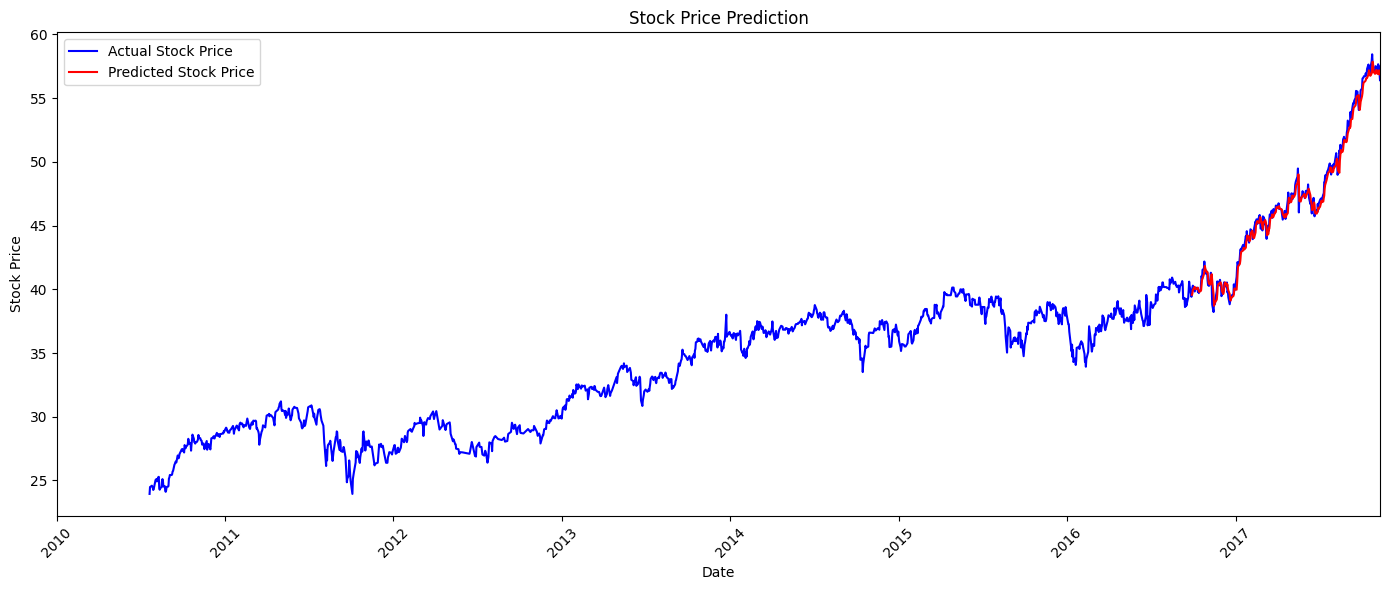

In [130]:
import datetime
# visualize to examine how well your mode's forecasts match the actual stock prices
# Get the dates for the test set (you'll still need this for plotting predictions)
test_dates = stock_data.index[train_size + n_steps:]

plt.figure(figsize=(14, 6))
plt.plot(stock_data.index, stock_data['Close'], color='blue', label='Actual Stock Price') # Plotting against the full index
plt.plot(test_dates, predictions, color='red', label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Format the x-axis dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(datetime.datetime(2010, 1, 1), stock_data.index.max())

plt.show()